In [1]:
import numpy as np
from matplotlib import pyplot as plt
import DataUtils as data

In [ ]:
# TODO: Use EM to re-estimate the A matrix

In [62]:
class KalmanFilter():
    """
    Initialization:
    1. Initialize state of the filter
    2. Initialize belief of the state

    Predict:
    1. Use process model to predict state at the next time step
    2. Adjust belief to account for hte uncertainty in prediction

    Update:
    1. Get a measurement & associated belief about its accuracy
    2. Compute residual between estimated state & measurement
    3. Compute scaling factor absed on whether the measurement or prediction
    is more accurate
    4. Set state between prediction & measurement based on scaling factor
    5. Update belief in the state based on how certain we are in the measurement
    """
    def __init__(self, prior, A, C, Q):
        '''

        '''
        self.prior = prior
        self.A = A
        self.C = C
        self.previous_mean = np.eye(3)
        self.previous_time = 0

        self.Q = Q # system cov

        self.mean = prior
        temp = np.random.rand(3)
        self.cov = np.diag(temp)

        self.Kalman_gain = None
        self.mean_predict = None
        self.cov_predict = None

    def predict(self, R):
        self.mean_predict = self.A @ self.prior
        self.cov_predict = self.A @ self.cov @ self.A.T + R

        self.Kalman_gain = self.cov_predict @ self.C.T @ np.linalg.inv( self.C @ self.cov_predict @ self.C.T + self.Q )

    def update(self, measurement, time):
        self.previous_mean = self.mean
        
        shape = self.Kalman_gain.shape[0]
        self.mean = self.mean_predict + self.Kalman_gain @ (measurement.reshape(shape,1) - (self.C @ self.mean_predict))
        self.cov = (np.eye(shape,dtype=float) - self.Kalman_gain @ self.C) @ self.cov_predict
        
        # temp = self.mean - self.previous_mean
        # time_elapsed = time - self.previous_time
        # self.previous_time = time
        # temp = temp / time_elapsed
        # temp = np.reshape(temp, (1,3))[0] + np.random.rand(3)
        # print(time_elapsed)
        # print(temp)
        # print(np.diag(temp))
        # self.A = np.diag(temp)
        self.A = np.diag(np.random.rand(3))
        
        
        
    def curr_state(self):
        return self.mean, self.cov

    def get_predictions(self, measurements):
        shape = self.cov.shape[0]

        states = np.zeros(shape=(shape, measurements.shape[1]),dtype=float)
        states[:,0] = self.prior.reshape(-1)
        for i in range(1,measurements.shape[1]):
            self.predict()
            self.update( measurements[:,i] )
            states[:,i] = self.currState()[0].reshape(-1)

        return states

In [6]:
# Load Data
data_interface = data.DataInterface(
    "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/gps.csv",
    "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/xsens_imu.csv",
    "C:/Users/erich/OneDrive/Desktop/UCI/CS 179/project/urban16/sensor_data/encoder.csv"
)

In [7]:
data_interface.reset()

In [64]:
# Create Kalman Filter
snapshot = data_interface.read()
gps_data = snapshot["gps_data"]
lon, lat, alt = gps_data[1], gps_data[2], gps_data[3]
R = gps_data[4:].reshape((3,3))
print(gps_data)
print(lon, lat, alt, "\n", R)

[1.52420511e+18 3.75250274e+01 1.26918918e+02 3.91520000e+01
 3.57843240e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.57843240e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.19451040e+01]
37.5250274 126.9189182 39.152 
 [[35.784324  0.        0.      ]
 [ 0.       35.784324  0.      ]
 [ 0.        0.       31.945104]]


In [65]:
radius = 6371
prior = np.array([[lon, lat, alt]]).T
C = np.eye(3)
C[0, 1] = 1/(radius * np.cos(np.radians(lat)))
C[1, 1] = 1/radius
Q = np.eye(3)
kf = KalmanFilter(prior, np.eye(3), C, Q)

In [66]:
timestamp = gps_data[0]
mean_arr = []
cov_arr = []

for t in range(1000):
    gps_snapshot = data_interface.read()["gps_data"]
    R = gps_snapshot[4:].reshape((3,3))
    kf.predict(R)
    kf.update(gps_snapshot[1:4], data_interface.get_current_time())
    m, c = kf.curr_state()
    mean_arr.append(m)
    cov_arr.append(c)
mean_arr = np.array(mean_arr)
cov_arr = np.array(cov_arr)

In [67]:
mean_arr[0]

array([[ 37.55747543],
       [127.64394502],
       [ 39.11999791]])

In [68]:
cov_arr[0]

array([[9.72843526e-01, 9.25330167e-03, 0.00000000e+00],
       [9.25330167e-03, 3.64006064e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.69760345e-01]])

In [69]:
mean_arr.shape

(1000, 3, 1)

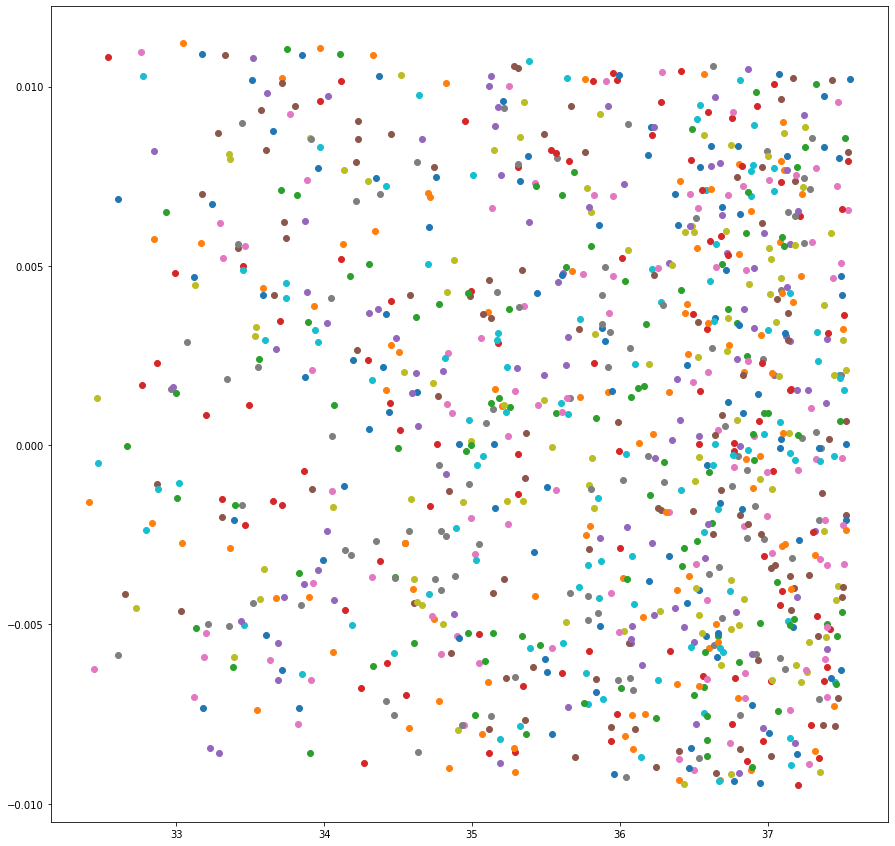

In [70]:
fig = plt.figure(figsize=(15, 15))
# axis1 = plt.axes(projection="3d")
# axis2 = plt.axes()


for i in mean_arr:
    converted_pts = C.T @ i
    # print(converted_pts)
    # axis.plot(converted_pts[0], converted_pts[1], converted_pts[2])
    # print(i)
    # axis1.scatter(converted_pts[0], converted_pts[1], converted_pts[2])
    plt.scatter(converted_pts[0], converted_pts[1])